In [1]:
import numpy as np
import pandas as pd

data = "/mnt/d/Data/Instacart/"

In [2]:
f = pd.read_hdf("/mnt/d/Data/Instacart/dataset.hdf", "train")

f['aisle_id'] = f.aisle_id.astype('category')
f['department_id'] = f.department_id.astype('category')
f['order_dow'] = f.order_dow.astype('category')
f['order_hour_of_day'] = f.order_hour_of_day.astype('category')
f['user_prod_reordered'] = f.user_prod_reordered.astype('category')
f['user_prod_recentlydiscovered'] = f.user_prod_recentlydiscovered.astype('category')

train = f[f['seed']<2].drop(['order_id', 'user_id', 'product_id', 'seed'], axis=1)
valid = f[f['seed']==3].drop(['order_id', 'user_id', 'product_id', 'seed'], axis=1)

valid_label = f[['order_id', 'user_id', 'product_id', 'label']][f['seed']==3]

del f

In [53]:
for itm in train.columns:
    pass

In [3]:
train.columns

Index(['label', 'user_nitems', 'user_norder', 'user_avg_prod_norder',
       'user_order_interval_avg', 'user_days_interval_avg',
       'user_ndistinctitems', 'user_nrdistinctitems', 'user_nritems',
       'user_interval', 'user_second_order_rate', 'user_avg_reorder_ratio',
       'user_nritem_ratio', 'user_nrdistinctitem_ratio',
       'user_nitem_per_order', 'user_nritem_per_order',
       'user_nritem_per_order_ratio', 'user_lastorder_interval',
       'user_lastorder_interval_ratio', 'user_prod_lastorder_interval',
       'user_prod_lastdays_interval', 'prod_norder', 'prod_nuser',
       'prod_nrorder', 'prod_nruser', 'prod_days_interval_avg',
       'prod_order_interval_avg', 'prod_second_order_ratio',
       'prod_ruser_ratio', 'prod_rorder_ratio', 'prod_rorder_per_ruser',
       'prod_order_per_user', 'user_prod_reordered', 'user_prod_norder',
       'user_prod_order_interval', 'user_prod_days_interval',
       'user_prod_reorder_rate', 'user_prod_recentlydiscovered',
       'u

<hr/>

Training using lightgbm



In [3]:
import lightgbm as lgb

X = lgb.Dataset(train.drop('label', axis=1), train['label'], )
V = lgb.Dataset(valid.drop('label', axis=1), valid['label'], reference=X)

In [48]:
from sklearn.metrics import f1_score, roc_auc_score

params = {
    'task': 'train',
    'boosting_type': 'rf',
    'objective': 'binary',
    'num_leaves': 1024,
    'metric': {'auc'},
    'feature_fraction': 0.5,
    'bagging_freq': 1,
    'bagging_fraction': 0.5
}

evals_result = {}

In [49]:
rf = lgb.train(params, X, valid_sets=[X,V], num_boost_round=200, evals_result=evals_result, early_stopping_rounds=20)

[1]	training's auc: 0.82406	valid_1's auc: 0.820367
Training until validation scores don't improve for 20 rounds.
[2]	training's auc: 0.831304	valid_1's auc: 0.82791
[3]	training's auc: 0.833272	valid_1's auc: 0.829848
[4]	training's auc: 0.833902	valid_1's auc: 0.830503
[5]	training's auc: 0.834179	valid_1's auc: 0.830858
[6]	training's auc: 0.834677	valid_1's auc: 0.831274
[7]	training's auc: 0.83497	valid_1's auc: 0.831543
[8]	training's auc: 0.835063	valid_1's auc: 0.831626
[9]	training's auc: 0.835235	valid_1's auc: 0.831814
[10]	training's auc: 0.835374	valid_1's auc: 0.831925
[11]	training's auc: 0.835425	valid_1's auc: 0.831964
[12]	training's auc: 0.83559	valid_1's auc: 0.832071
[13]	training's auc: 0.835705	valid_1's auc: 0.832157
[14]	training's auc: 0.835731	valid_1's auc: 0.832192
[15]	training's auc: 0.835713	valid_1's auc: 0.83214
[16]	training's auc: 0.835746	valid_1's auc: 0.832183
[17]	training's auc: 0.835772	valid_1's auc: 0.8322
[18]	training's auc: 0.835776	valid_

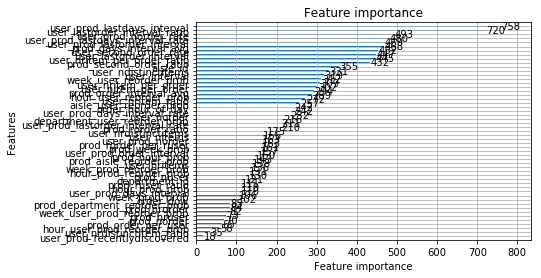

In [8]:
import matplotlib.pyplot as plt

ax = lgb.plot_importance(gbdt)
plt.show()

In [37]:
rf.save_model("model.cv.txt", gbdt.best_iteration)

In [60]:
rf.best_score['valid_1']['auc']

0.83251475820058785

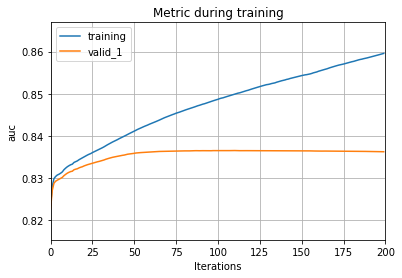

In [6]:
import matplotlib.pyplot as plt

ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()

In [6]:
Yt = gbdt.predict(valid.drop('label', axis=1), num_iteration=gbdt.best_iteration)

In [23]:
Yt

array([ 0.02291397,  0.04002087,  0.04375576, ...,  0.0721013 ,
        0.10516685,  0.07783413])

In [8]:
valid_label['pred_prob'] = Yt

In [52]:
%%timeit -r 1 -n 1
valid_label[['user_id', 'label', 'pred_prob']].groupby('user_id').apply(lambda x: f1_score(x.label, x.pred_prob>0.17)).mean()

/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


1 loop, best of 1: 18.3 s per loop


In [50]:
valid_label[['user_id', 'label', 'pred_prob']].groupby('user_id').apply(lambda x: f1_score(x.label, x.pred_prob>0.22)).mean()

/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.36300076039342022

In [9]:
gp = valid_label[['user_id', 'label', 'pred_prob']].groupby('user_id')

In [13]:
np.mean

In [15]:
name

206198

In [18]:
from sklearn.externals.joblib import Parallel, delayed

def uf1score(x):
    return f1_score(x.label, x.pred_prob>0.22)

%timeit -r 1 -n 1 np.mean(Parallel(n_jobs=2)(delayed(uf1score)(group) for _, group in gp))

/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


1 loop, best of 1: 14.3 s per loop


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.optimize import minimize_scalar

def uf1score(x, y):
    return f1_score(x.label, x.pred_prob>y)

def obj(y):
    return -np.mean(Parallel(n_jobs=4)(delayed(uf1score)(group, y) for _, group in valid_label[['user_id', 'label', 'pred_prob']].groupby('user_id')))

th = minimize_scalar(obj, bracket=(0.15, 0.25), method='brent', tol=1e-5)
valid_label['pred'] = np.require(valid_label.pred_prob>th.x, dtype = np.int)


/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-package

/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ike/.miniconda3/envs/intel/

/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-package

/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5

/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ike/.miniconda3/envs/intel/

/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-package

In [21]:
th.x

0.17382061466374635

In [29]:
prec = lambda g: precision_score(valid_label.ix[g.index]['label'].values, valid_label.ix[g.index]['pred'].values)
reca = lambda g: recall_score(valid_label.ix[g.index]['label'].values, valid_label.ix[g.index]['pred'].values)
accu = lambda g: accuracy_score(valid_label.ix[g.index]['label'].values, valid_label.ix[g.index]['pred'].values)
f1sc = lambda g: f1_score(valid_label.ix[g.index]['label'].values, valid_label.ix[g.index]['pred'].values)

valid_label[['user_id', 'label', 'pred']].groupby(by='user_id').agg({'pred': {'precision': prec, 'recall': reca, 'accuracy': accu, 'f1': f1sc}})

/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


pred                              
           recall        f1 precision  accuracy
user_id                                        
13       0.750000  0.500000  0.375000  0.793103
14       0.500000  0.571429  0.666667  0.957746
17       0.666667  0.500000  0.400000  0.951807
24       1.000000  1.000000  1.000000  1.000000
42       0.666667  0.533333  0.444444  0.883333
46       0.666667  0.421053  0.307692  0.822581
48       0.400000  0.160000  0.100000  0.637931
49       0.000000  0.000000  0.000000  0.933333
64       0.714286  0.526316  0.416667  0.684211
70       1.000000  0.666667  0.500000  0.985915
78       0.000000  0.000000  0.000000  0.947368
81       1.000000  0.333333  0.200000  0.800000
87       1.000000  0.583333  0.411765  0.836066
93       0.000000  0.000000  0.000000  1.000000
95       0.500000  0.428571  0.375000  0.836735
96       0.500000  0.333333  0.250000  0.785714
112      0.000000  0.000000  0.000000  0.909091
119      0.285714  0.333333  0.400000  0.500000
130      0.500000  0.315789  0.230769  0.580645
142      0.400000  0.285714  0.222222  0.857143
143      0.555556  0.357143  0.263158  0.844828
160      0.785714  0.448980  0.314286  0.780488
174      0.333333  0.200000  0.142857  0.904762
183      0.555556  0.370370  0.277778  0.706897
185      0.000000  0.000000  0.000000  0.882353
201      1.000000  0.400000  0.250000  0.916667
204      0.352941  0.400000  0.461538  0.903226
205      0.666667  0.500000  0.400000  0.764706
219      0.357143  0.333333  0.312500  0.869281
242      0.750000  0.461538  0.333333  0.904110
...           ...       ...       ...       ...
205874   0.500000  0.461538  0.428571  0.915663
205881   0.300000  0.272727  0.250000  0.813953
205887   0.666667  0.444444  0.333333  0.833333
205900   0.000000  0.000000  0.000000  0.754386
205917   0.428571  0.333333  0.272727  0.903226
205921   0.875000  0.437500  0.291667  0.727273
205924   0.000000  0.000000  0.000000  0.886792
205928   0.750000  0.428571  0.300000  0.703704
205942   0.400000  0.210526  0.142857  0.794521
205948   0.500000  0.571429  0.666667  0.928571
205954   0.428571  0.333333  0.272727  0.630769
205962   0.714286  0.526316  0.416667  0.790698
205989   0.500000  0.478261  0.458333  0.747368
206005   0.166667  0.153846  0.142857  0.880435
206011   0.500000  0.500000  0.500000  0.981481
206032   0.000000  0.000000  0.000000  0.938776
206040   0.428571  0.352941  0.300000  0.855263
206043   0.600000  0.413793  0.315789  0.875000
206065   0.250000  0.181818  0.142857  0.785714
206075   0.250000  0.166667  0.125000  0.677419
206082   0.850000  0.596491  0.459459  0.634921
206084   0.000000  0.000000  0.000000  0.872727
206091   0.500000  0.285714  0.200000  0.920635
206093   0.666667  0.444444  0.333333  0.880952
206100   0.000000  0.000000  0.000000  0.666667
206113   0.625000  0.500000  0.416667  0.782609
206115   1.000000  0.480000  0.315789  0.593750
206174   0.375000  0.230769  0.166667  0.920635
206176   1.000000  0.428571  0.272727  0.829787
206198   0.000000  0.000000  0.000000  0.971429

[26242 rows x 4 columns]

In [31]:
Out[29].to_csv("debug.tsv", sep='\t')

In [21]:
valid_label.head()

,order_id,user_id,product_id,label,pred_prob,pred
399,1827621,13,32850,0,0.023246,0
400,1827621,13,44142,0,0.038920,0
401,1827621,13,32446,0,0.045136,0
402,1827621,13,4210,1,0.874250,1
403,1827621,13,27086,1,0.875562,1


In [38]:
valid_label.to_csv("DSATdebug.tsv", sep='\t', index=False)

In [35]:
valid_label.drop('f1', axis=1, inplace=True)

In [25]:
from scipy.optimize import minimize_scalar

def obj(y):
    return -valid_label[['user_id', 'label', 'pred_prob']].groupby('user_id').apply(lambda x: f1_score(x.label, x.pred_prob>y)).mean()

th = minimize_scalar(obj, bracket=(0.15, 0.25), method='brent', tol=1e-5)

/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [26]:
th.x

0.16753284563176027

In [30]:
th.success

True

<hr/>

predict and submit

In [15]:
f1_score([0,0,0], [0,0,0])

0.0

In [2]:
test = pd.read_hdf("/mnt/d/Data/Instacart/dataset.hdf", "test")
#test.drop(['user_prod_recentlydiscovered'], axis=1, inplace=True)

In [4]:
train = train.append(valid)

In [12]:
import lightgbm as lgb

X = lgb.Dataset(train.drop('label', axis=1), train['label'], categorical_feature=['aisle_id', 'department_id', 'order_dow', 'order_hour_of_day', 'user_prod_reordered'])


In [13]:
gbdt = lgb.train(params, X, num_boost_round=160)

In [3]:
import lightgbm as lgb

In [4]:
gbdt = lgb.Booster(model_file="model.txt")

In [5]:
Y = gbdt.predict(test.drop(['order_id', 'user_id', 'product_id'], axis=1))

In [10]:
test['label'] = Y>0.5

In [11]:
Y

array([ 0.78030924,  0.90250989,  0.67640252, ...,  0.2185149 ,
        0.17646151,  0.29155882])

In [12]:
d = dict()
for row in test.itertuples():
    if row.label:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test.order_id:
    if order not in d:
        d[order] = 'None'

In [13]:
sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('result.csv', index=False)

In [21]:
train

,label,second_order_ratio,avg_reorder_ratio,user_reorder_ratio,days_since_prior_order,user_product_order_cnt,user_prod_order_rate,user_prod_last_vacancy,user_prod_order_freq
0,1,0.582500,4.473875,0.759259,14.0,10,1.000000,1,1.000000
2,0,0.529482,3.857058,0.759259,14.0,10,1.000000,1,1.000000
11,0,0.527426,3.082390,0.759259,14.0,1,0.100000,6,1.000000
12,0,0.495725,2.856348,0.759259,14.0,1,0.100000,6,1.000000
15,1,0.634271,4.278772,0.759259,14.0,1,0.100000,1,1.000000
18,0,0.582500,4.473875,0.515000,28.0,1,0.030303,24,1.000000
24,0,0.543279,3.699053,0.515000,28.0,5,0.151515,1,0.172414
26,0,0.487881,3.049811,0.515000,28.0,1,0.030303,13,1.000000
29,0,0.557770,3.134867,0.515000,28.0,1,0.030303,24,1.000000
30,0,0.564679,4.197768,0.515000,28.0,3,0.090909,6,0.230769


In [39]:
# send mail

import smtplib
from email.message import EmailMessage

msg = EmailMessage()
msg.set_content("""
Bonjour! Parameter Tunning has completed. 

Parameter:
{0}

""".format(tempstring))

msg['Subject'] = "Parameter Tunning Completed."
msg['From'] = "azureuser@cloudymiao.cloudapp.net"
msg['To'] = "geniusxiaoguai@gmail.com"

# Send the message via our own SMTP server.
s = smtplib.SMTP('localhost')
s.send_message(msg)
s.quit()

ConnectionRefusedError: [Errno 111] Connection refused

In [37]:
from pprint import PrettyPrinter

pp = PrettyPrinter()

tempstring = pp.pformat(params)

In [38]:
tempstring

"{'bagging_fraction': 0.95,\n 'bagging_freq': 5,\n 'boosting_type': 'gbdt',\n 'categorical_column': [28, 31, 36, 37, 48, 49],\n 'feature_fraction': 0.9,\n 'max_bin': 255,\n 'max_depth': 10,\n 'metric': {'auc'},\n 'num_leaves': 128,\n 'objective': 'binary',\n 'task': 'train',\n 'verbose': 1}"

In [51]:
from datetime import datetime

datetime.today().strftime("%a, %d %b %Y %H:%M:%S")

'Sat, 22 Jul 2017 17:18:36'

In [53]:
tempstr = valid_label.ix[:5, :].to_html()

In [54]:
tempstr

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>order_id</th>\n      <th>user_id</th>\n      <th>product_id</th>\n      <th>label</th>\n      <th>pred_prob</th>\n      <th>pred</th>\n    </tr>\n  </thead>\n  <tbody>\n  </tbody>\n</table>'

In [57]:
pd.DataFrame({
    "F1": [1,1,1,1,1],
    'AUC': [0,0,0,0,9]
}, index=pd.Index([2,3,4,5,6], name="Param"))

,AUC,F1
Param,,
2,0,1
3,0,1
4,0,1
5,0,1
6,9,1


In [4]:
from azure.storage.blob import BlockBlobService, ContentSettings

In [2]:
import os

block_blob_service = BlockBlobService(account_name=os.environ['AZURE_STORAGE_IKELY_ACCOUNT'], 
                                      account_key=os.environ['AZURE_STORAGE_IKELY_KEY'])

In [5]:
block_blob_service.create_blob_from_path(
    'temp',
    'dev',
    'result.csv',
    content_settings=ContentSettings(content_type='text/csv')
            )